In [1]:
import os
import h5py
import shutil
import pandas as pd
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy import table
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
from astropy.visualization import make_lupton_rgb
from collections import Counter
from tensorflow import keras
from astropy.wcs import WCS,utils
import random
from functions import create_cutouts

In [2]:
file_name = "/confirmed_cfis_64p.h5"

In [3]:
#useful directories
os.path.expandvars("$SLURM_TMPDIR")

src = os.path.expandvars("$SCRATCH") + file_name
dest = os.path.expandvars("$SLURM_TMPDIR") + "/"

image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"
label_dir = "labels/"

In [4]:
hf = h5py.File(os.path.expandvars("$SCRATCH")+file_name, "r")
#hf.close()


#shutil.copy2(src, dest)

In [17]:
img_group_name = '197.271/IMAGES'
j=0
filters = ["CFIS u/", "PS1 g/", "CFIS r/", "PS1 i/", "PS1 z/"]
filter_dict = {k:v for v,k in enumerate(filters)}
f = 'CFIS u/'
hf[img_group_name + f"/c{j}-r"][...,filter_dict[f]].shape

(64, 64)

In [39]:
hf = h5py.File(dest + file_name, "w")

In [18]:
hf.close()

In [36]:
tile_file = open(image_dir + "tiles_cand.list", "r")
tile_list = tile_file.readlines()
for i in range(len(tile_list)):
    tile_list[i] = tile_list[i][:-1] # Remove new line characters
    #print(tile_list[i])
tile_file.close()

In [37]:
label_subdirs = ["stronglensdb_confirmed_unige/", "stronglensdb_candidates_unige/", "canameras2020/",
                 "huang2020a_grade_A/", "huang2020a_grade_B/", "huang2020a_grade_C/", 
                 "huang2020b_grade_A/", "huang2020b_grade_B/", "huang2020b_grade_C/"]
filters = ["CFIS u/", "PS1 g/", "CFIS r/", "PS1 i/", "PS1 z/"]
filter_dict = {k:v for v,k in enumerate(filters)}

In [9]:
len_cat = []
for label_subdir in [label_subdirs[0]]:
    for f in [filters[0],filters[2]]:
        subdir = label_dir + label_subdir + f
        for csv in os.listdir(subdir):
            if csv != ".ipynb_checkpoints":
                tile_id = csv[:7] 
               
                tile_name = f.split(" ")[0] + "." + tile_id + "." + f.split(" ")[1][0]
                
                cat = table.Table.read(image_dir+ tile_name + '.cat', format="ascii.sextractor")
                len_cat.append(len(cat))

In [10]:
min(len_cat)

430

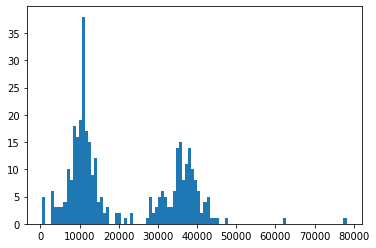

In [9]:
#number of cutouts per tile for u and r tiles
plt.hist(len_cat, bins = 100);

right now, taking u confirmed cutouts (and saves coordinates for tile in r later) + new 300 cutouts 
then for r list, taking new cutout (confirmed in r) + u confirmed in r + 300 same cutouts from u in r

In [41]:
csv


'452.239_labels.csv'

In [65]:
for i in list(hf.keys()):
    del hf[i]
hf.keys()

<KeysViewHDF5 []>

In [75]:
#clean directory
for label_subdir in [label_subdirs[0]]:
    for f in [filters[2],filters[0]]:
        subdir = label_dir + label_subdir + f
        print(subdir)
        z = 1
        for csv in os.listdir(subdir):
            if csv == '.ipynb_checkpoints':
                del csv
            else:
                print(csv)
            

labels/stronglensdb_confirmed_unige/CFIS r/
197.271_labels.csv
248.272_labels.csv
203.263_labels.csv
165.270_labels.csv
201.311_labels.csv
241.290_labels.csv
204.278_labels.csv
147.288_labels.csv
260.284_labels.csv
234.295_labels.csv
206.264_labels.csv
254.287_labels.csv
246.289_labels.csv
228.262_labels.csv
070.320_labels.csv
340.274_labels.csv
246.291_labels.csv
403.238_labels.csv
269.283_labels.csv
238.293_labels.csv
230.296_labels.csv
188.307_labels.csv
164.282_labels.csv
264.299_labels.csv
236.293_labels.csv
442.244_labels.csv
211.252_labels.csv
407.242_labels.csv
162.275_labels.csv
238.291_labels.csv
424.243_labels.csv
175.268_labels.csv
203.285_labels.csv
245.289_labels.csv
249.287_labels.csv
243.292_labels.csv
261.266_labels.csv
175.271_labels.csv
253.263_labels.csv
349.267_labels.csv
266.298_labels.csv
380.255_labels.csv
245.284_labels.csv
253.286_labels.csv
264.267_labels.csv
259.286_labels.csv
226.273_labels.csv
267.284_labels.csv
204.257_labels.csv
262.285_labels.csv
201.28

In [66]:
broken_tiles = []
prev_conf = {'197.271': None} #dictionary of previously seen tiles
cutout_size = 64
for label_subdir in [label_subdirs[0]]:
    for f in [filters[0],filters[2]]:
        subdir = label_dir + label_subdir + f
        print(subdir)
        z=0
        for csv in ['297.255_labels.csv']:
            if z < 2:
                z+=1
                tile_id = csv[:7] # XXX.XXX id
                print('id', tile_id)
    #                 img_group_name = label_subdir + tile_id + "/" + f + "IMAGES"
    #                 wt_group_name = label_subdir + tile_id + "/" + f + "WEIGHTS"

                img_group_name =  tile_id + "/" + "IMAGES"
                wt_group_name  =  tile_id + "/" + "WEIGHTS"
                tile_name = f.split(" ")[0] + "." + tile_id + "." + f.split(" ")[1][0]
               
                #FILES
                #weight
                if "CFIS" in f:
                    wt_name = ".weight.fits.fz"
                    wt_index = 1
                else:
                    wt_name = ".wt.fits"
                    wt_index = 0
                
                #files
                img_fits = fits.open(image_dir + tile_name + ".fits", memmap=True)
                wt_fits  = fits.open(image_dir + tile_name + wt_name, memmap=True)
                cat = table.Table.read(image_dir + tile_name + '.cat', format="ascii.sextractor")

                new_group = False
                if img_group_name not in hf:
                    new_group = True
                    img_group = hf.create_group(img_group_name)
                    wt_group = hf.create_group(wt_group_name)

                    img_cutout_all = np.random.normal(loc = 0.5,scale= 0.13, size=(cutout_size, cutout_size,5))
                    #img_cutout = np.zeros((cutout_size, cutout_size, 5)) 
                    wt_cutout_all  = np.zeros((cutout_size, cutout_size, 5))

                    #generate list of random cutouts
                    rand_cutouts = random.sample(range(len(cat)),2)

                else:
                    img_group = hf[img_group_name]
                    wt_group = hf[wt_group_name]

                    #want the same cutouts as previous, with previous catalogue (u)
                    list_cutouts = list(hf[img_group_name].keys())
                    #prev random cutouts
                    rand_cutouts = [int((i[1:]).split("-")[0]) for i in list_cutouts if  'u' not in (i[1:]).split("-")] 
                    #prev confirmed cutouts
                    cat_prev = table.Table.read(image_dir + tile_name[:-1] + 'u' + '.cat', format="ascii.sextractor")


                #### make cutouts
                count = 0 
                #candidates cutouts
                df = pd.read_csv(subdir + csv)
                nlabels = len(df)
                
            #----create candidate cutout from previous catalogue----#    
                if (tile_id + '-0') in prev_conf:
                    j = 0 
                    try_tile = tile_id + '-0' #first cutout is labelled with 0 for sure
                    if try_tile in prev_conf:
                        (x,y) =prev_conf[tile_id + '-' + str(count)] 
                        try:
                            (img_cutout, wt_cutout) = create_cutouts(img_fits[0], wt_fits[wt_index], x, y, tile_name[-1])
                        except:
                            broken_tiles.append(tile_name) 
                            pass
                        
                        count += 1
                        j+=1
                        try_tile = tile_id + f'-{j}'
#                         print('previous done')
                    else:
#                         print('all u cutouts done in r')
                         break
                    
#                     print('onto new confirmed r cutouts')
                    
            #----create candidate cutout from current catalogue----#    
                count = 0
                for n in range(nlabels): 
                    x = df["x"][n]
                    y = df["y"][n]
                    #save x,y for u channel
                    if tile_name[-1] == 'u':
                        prev_conf[tile_id + '-' + str(count)] = (x,y)
                    #make cutout
                    try:
                        (img_cutout, wt_cutout) = create_cutouts(img_fits[0], wt_fits[wt_index], x, y, tile_name[-1])
                    except:
                        broken_tiles.append(tile_name) 
                        pass

                    print('should be 0', count)
                    count += 1
                    
                    print('new cand')
                    img_cutout_all[:,:,filter_dict[f]] = img_cutout
                    wt_cutout_all[:,:,filter_dict[f]]  = wt_cutout

                    img_group.create_dataset(f"c{n}-"+tile_name[-1], data=img_cutout_all)
                    wt_group.create_dataset(f"c{n}-"+tile_name[-1], data=wt_cutout_all)
                       
                print(f'done {count}')
                
            #----create extra random cutout from current catalogue----#   
                for n in rand_cutouts:
                    #if cat["FLAGS"][n] != 0 or cat["MAG_AUTO"][n] >= 99.0 or cat["MAGERR_AUTO"][n] <= 0 or cat["MAGERR_AUTO"][n] >= 1:
                    #    continue
                
                    count += 1
                    if new_group is True: #create cutout from current catalogue if new group
                        x = cat["X_IMAGE"][n]
                        y = cat["Y_IMAGE"][n]
                        try:
                            (img_cutout, wt_cutout) = create_cutouts(img_fits[0], wt_fits[wt_index], x, y, f[-2])
                        except:
                            broken_tiles.append(tile_name) 
                            pass

                        img_cutout_all[:,:,filter_dict[f]] = img_cutout
                        wt_cutout_all[:,:,filter_dict[f]]  = wt_cutout
                        
                        img_group.create_dataset(f"c{n}", data=img_cutout_all)
                        wt_group.create_dataset(f"c{n}", data=wt_cutout_all)
                    
                    else:                 #add cutout to existing group
                        x = cat_prev["X_IMAGE"][n]
                        y = cat_prev["Y_IMAGE"][n]
                        try:
                            (img_cutout, wt_cutout) = create_cutouts(img_fits[0], wt_fits[wt_index], x, y, f[-2])
                        except:
                            broken_tiles.append(tile_name) 
                            pass

                        if img_cutout is None:
                            img_cutout = np.random.normal(loc = 0.5,scale= 0.13, size=(cutout_size, cutout_size))
                            wt_cutout  = np.zeros((cutout_size, cutout_size))
                        else:
                            hf[img_group_name + f"/c{n}"][...,filter_dict[f]] = img_cutout
                            hf[wt_group_name + f"/c{n}"][...,filter_dict[f]] = wt_cutout

                    print(len(rand_cutouts),n, count)
                print(f'done {count}')
       
                img_fits.close()
                wt_fits.close()
        print(f"Finished {label_subdir}")

labels/stronglensdb_confirmed_unige/CFIS u/
id 297.255
should be 0 0
new cand
done 1
2 10131 2
2 5747 3
done 3
Finished stronglensdb_confirmed_unige/
labels/stronglensdb_confirmed_unige/CFIS r/
id 297.255
should be 0 0
new cand
done 1
2 10131 2
2 5747 3
done 3
Finished stronglensdb_confirmed_unige/


In [73]:
broken_tiles
np.savetxt("broken_tiles.csv", broken_tiles, delimiter =", ", fmt ='% s')

In [56]:
hf['297.255/WEIGHTS'].keys()

<KeysViewHDF5 ['c0-r', 'c0-u', 'c2259', 'c6945']>

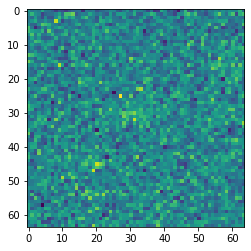

In [62]:
plt.imshow(np.array(hf['297.255/IMAGES/c6945'])[...,2])

---
# Testing

In [79]:
img_cutout

In [68]:
plt.imshow(img_cutout.shape

(64, 64)

In [127]:
hf.keys()

<KeysViewHDF5 ['050.212', '147.288', '165.270', '197.271', '201.311', '203.263', '204.278', '206.264', '228.262', '234.295', '241.290', '248.272', '260.284', '314.228', '324.225', '640.188']>

In [133]:
hf['165.270/IMAGES'].keys()

<KeysViewHDF5 ['c0-r', 'c0-u', 'c1861', 'c2418']>

In [134]:
tile = '165.270'
cut  = 'c2644'
r_band_only = np.array(hf['165.270/IMAGES/c0-r'])
u_band_only = np.array(hf['165.270/IMAGES/c0-u'])
tile        = np.array(hf['165.270/IMAGES/c1861'])

weight = np.array(hf['165.270/WEIGHTS/c1861'])
r_w    = np.array(hf['165.270//WEIGHTS/c0-r'])
u_w    = np.array(hf['165.270//WEIGHTS/c0-u'])

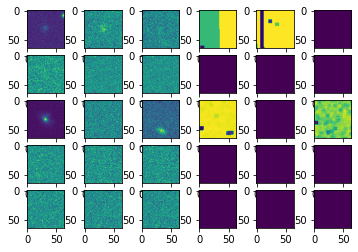

In [135]:
fig, axes = plt.subplots(5, 6)
for i in range(5):
    axes[i][0].imshow(r_band_only[...,i])
    axes[i][1].imshow(u_band_only[...,i])
    axes[i][2].imshow(tile[...,i])
    axes[i][3].imshow(r_w[...,i])
    axes[i][4].imshow(u_w[...,i])
    axes[i][5].imshow(weight[...,i])

In [65]:
hf.close()
src = os.path.expandvars("$SLURM_TMPDIR") + "/labelled_cutouts_64p.h5"
dest = os.path.expandvars("$SCRATCH") + "/"
shutil.copy2(src, dest)

'/scratch/anahoban/labelled_cutouts_64p.h5'

In [136]:
hf.close()

In [8]:
tile_ids = list(hf.keys())

In [11]:
n_cutouts = 0
for i in range(len(tile_ids)):
    n = len(hf.get(tile_ids[i] + "/IMAGES"))
    n_cutouts += n
print(n_cutouts)


103981
